In [2]:
# -*- coding: utf-8 -*-
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt
#sdf

In [3]:
class1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware'];
class2 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'];
class1_train = fetch_20newsgroups(subset = 'train', categories = class1, shuffle=True, random_state=42, remove=('headers','footers','quotes'));
class2_train = fetch_20newsgroups(subset = 'train', categories = class2, shuffle=True, random_state=42, remove=('headers','footers','quotes'));

## Problem 1)

In [4]:
from sklearn.feature_extraction import text
import re
import nltk 
import string
import numpy as np
from sklearn.feature_extraction import text

In [5]:
stop_words = text.ENGLISH_STOP_WORDS

from nltk.stem.snowball import SnowballStemmer
from nltk.tag import pos_tag
stemmer = SnowballStemmer("english")

def tokenizer_fun(text):
    new_text = re.sub(r'[^A-Za-z]', " ", text)
    new_text = re.sub("[,.-:/()?{}*$#&]"," ",new_text)  # remove all symbols
    new_text = "".join([ch for ch in new_text if ch not in string.punctuation])  # remove all punctuation
    new_text = "".join(ch for ch in new_text if ord(ch) < 128)  # remove all non-ascii characters
    new_text = new_text.lower() # convert to lowercase
    tokens =[word for sent in nltk.sent_tokenize(new_text) for word in nltk.word_tokenize(sent)]
    new_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]{2,}', token):
            new_tokens.append(token)     
    stem = [stemmer.stem(t) for t in new_tokens]
    tagged_sent = pos_tag(stem)
    new_stem = [word for word,pos in tagged_sent if pos == 'NN'] # remove all non-noun words
    return new_stem


In [364]:
from sklearn.datasets import fetch_20newsgroups
total_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, categories = class1+class2, remove=('headers','footers','quotes'))
total_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, categories = class1+class2, remove=('headers','footers','quotes'))

from sklearn.feature_extraction.text import TfidfVectorizer
# Normalize features
n_features = 10000
TFxIDF = TfidfVectorizer(analyzer='word',tokenizer=tokenizer_fun, stop_words=stop_words,token_pattern='[a-zA-Z]{2,}', norm = 'l2', max_df=0.95, min_df=2, max_features=n_features)
TFxIDF_train = TFxIDF.fit_transform(total_train.data)
TFxIDF_test  = TFxIDF.transform(total_test.data)

In [365]:
print TFxIDF_train.shape
print TFxIDF_test.shape

(4732, 9993)
(3150, 9993)


In [366]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [367]:
tfidf_feature_names = TFxIDF.get_feature_names()

## Problem 2)

In [368]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, max_iter = 1000, random_state=42).fit(TFxIDF_train)

In [369]:
# group the subclasses into 2 superclasses 
test_target_group = [ int(x / 4) for x in total_test.target]

In [370]:
test_target_group[20:40]

[1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]

In [371]:
kmeans_predict = kmeans.predict(TFxIDF_test)

In [372]:
kmeans_predict[20:50]

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0])

In [373]:
if sum(abs(kmeans_predict-test_target_group))>len(kmeans_predict)/2:
    i = 0
    for candidate in kmeans_predict:
        
        if candidate == 1:
            kmeans_predict[i] = 0
        elif candidate == 0:
            kmeans_predict[i] = 1
        i = i+1


In [374]:
sum(abs(kmeans_predict-test_target_group))

735

Confusion matrix, without normalization
[[ 844  716]
 [  19 1571]]
Normalized confusion matrix
[[ 0.54  0.46]
 [ 0.01  0.99]]


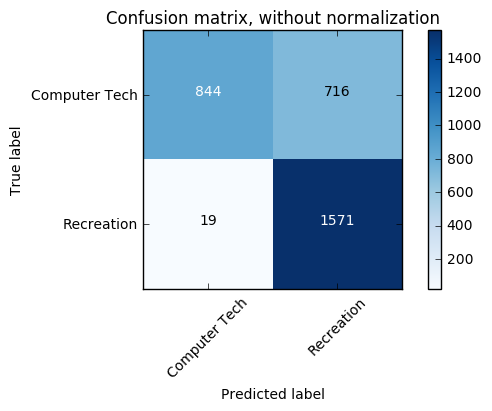

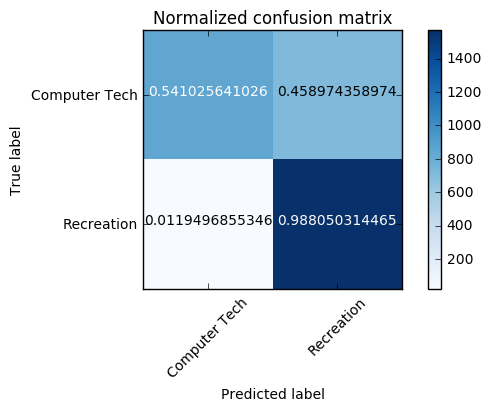

In [375]:
from sklearn.metrics import confusion_matrix
import itertools
class_names = ['Computer Tech', 'Recreation']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_target_group, kmeans_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### homogeneity score

In [376]:
# A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

In [377]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(test_target_group, kmeans_predict)  

0.30711733196948748

### completeness score

In [378]:
# A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

In [379]:
from sklearn.metrics.cluster import completeness_score
completeness_score(test_target_group, kmeans_predict)

0.36252713800633013

### adjusted rand index

In [380]:
# The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

In [381]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(test_target_group, kmeans_predict)

0.284250349488987

### adjusted mutual information score

In [382]:
# Adjusted mutual information score measures mutual information between the cluster label distribution and the groud truth label distributions

In [383]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(test_target_group, kmeans_predict)

0.33367404362796677

## Problem 3)

In [30]:
# LSI, Truncated SVD

In [480]:
from sklearn.decomposition import TruncatedSVD
n_components = 162
svd = TruncatedSVD(n_components=n_components, algorithm='arpack')
train_LSI = svd.fit_transform(TFxIDF_train)
test_LSI  = svd.transform(TFxIDF_test)

In [481]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, max_iter = 1000, random_state=42).fit(train_LSI)

In [482]:
kmeans_predict = kmeans.predict(test_LSI)
kmeans_predict[0:20]

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1])

In [483]:
if sum(abs(kmeans_predict-test_target_group))>len(kmeans_predict)/2:
    i = 0
    for candidate in kmeans_predict:
        
        if candidate == 1:
            kmeans_predict[i] = 0
        elif candidate == 0:
            kmeans_predict[i] = 1
        i = i+1
sum(abs(kmeans_predict-test_target_group))

Confusion matrix, without normalization
[[ 894  666]
 [  21 1569]]
Normalized confusion matrix
[[ 0.57  0.43]
 [ 0.01  0.99]]


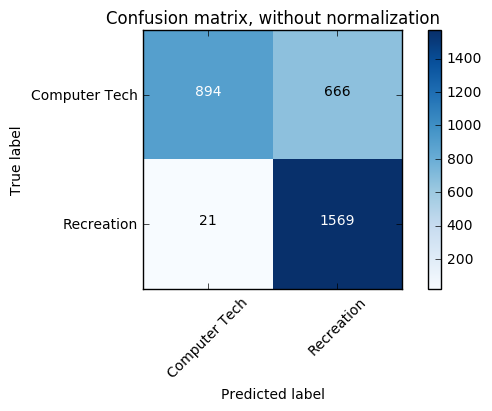

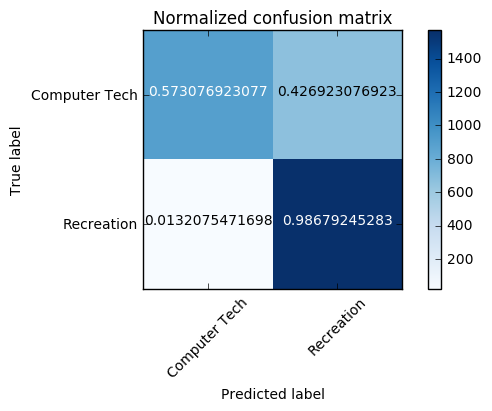

In [485]:
from sklearn.metrics import confusion_matrix
import itertools
class_names = ['Computer Tech', 'Recreation']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_target_group, kmeans_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [215]:
# SparsePCA, Sparse Principal Component Analysis

In [219]:
from sklearn.decomposition import SparsePCA
pca = SparsePCA(n_components=100)
pca.fit(TFxIDF_data.toarray())

SparsePCA(U_init=None, V_init=None, alpha=1, max_iter=1000, method='lars',
     n_components=100, n_jobs=1, random_state=None, ridge_alpha=0.01,
     tol=1e-08, verbose=False)

In [220]:
pca

SparsePCA(U_init=None, V_init=None, alpha=1, max_iter=1000, method='lars',
     n_components=100, n_jobs=1, random_state=None, ridge_alpha=0.01,
     tol=1e-08, verbose=False)

In [ ]:
from sklearn.datasets import fetch_20newsgroups
total_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, categories = class1+class2, remove=('headers','footers','quotes'))

from sklearn.feature_extraction.text import TfidfVectorizer
TFxIDF = TfidfVectorizer(analyzer='word',tokenizer=tokenizer_fun, stop_words=stop_words,token_pattern='[a-zA-Z]{2,}',)
TFxIDF_data = TFxIDF.fit_transform(total_train.data)

In [ ]:
# NMF, Non-Negative Matrix Factorization

In [564]:
from sklearn.decomposition import NMF
n_components = 60
nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5).fit(TFxIDF_train)
train_NMF = nmf.fit_transform(TFxIDF_train)
test_NMF  = nmf.transform(TFxIDF_test)

In [565]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, max_iter = 1000, random_state=42).fit(train_NMF)

In [566]:
kmeans_predict = kmeans.predict(test_NMF)

In [567]:
test_target_group[20:40]

[1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]

In [568]:
kmeans_predict[20:40]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [569]:
if sum(abs(kmeans_predict-test_target_group))>len(kmeans_predict)/2:
    i = 0
    for candidate in kmeans_predict:
        
        if candidate == 1:
            kmeans_predict[i] = 0
        elif candidate == 0:
            kmeans_predict[i] = 1
        i = i+1
sum(abs(kmeans_predict-test_target_group))

886

Confusion matrix, without normalization
[[ 694  866]
 [  20 1570]]
Normalized confusion matrix
[[ 0.44  0.56]
 [ 0.01  0.99]]


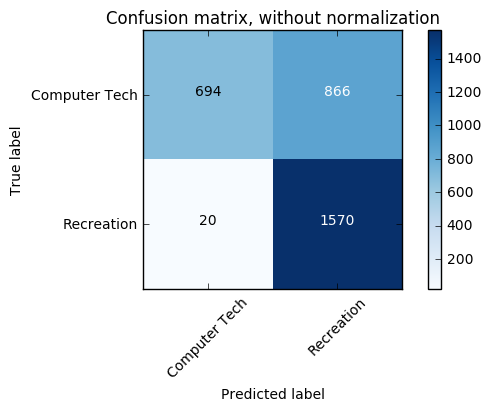

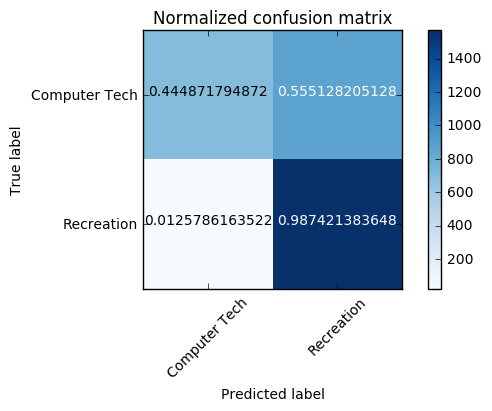

In [570]:
from sklearn.metrics import confusion_matrix
import itertools
class_names = ['Computer Tech', 'Recreation']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_target_group, kmeans_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()